# Import

In [74]:
import geopandas as gpd
import pandas as pd
pd.set_option('display.max_columns', 500)

import matplotlib.pyplot as plt
import numpy as np

from dotenv import load_dotenv
import os

load_dotenv()

True

# Open df

In [75]:
# h3
LOCAL_FILE_PATH = os.getenv('LOCAL_FILE_PATH')
h3_index = gpd.read_file(f'{LOCAL_FILE_PATH}h3_index_no_restriction_EN.gpkg')

print(h3_index.shape)
h3_index.head(3)

(23636, 25)


,h3_index,h3_resolution,nm_city,nm_state_abbrev,fl_slope_class_1,fl_slope_class_2,fl_slope_class_3,fl_slope_class_4,nr_distance_urban_growth_2020_2022_m,nr_distance_road_m,nr_distance_highways_m,nr_distance_urban_area_m,nr_poi_positive,nr_poi_negative,fl_construction_restriction,nr_population_ibge22,nr_households_ibge22,rt_people_households_ibge22,nr_monthly_income_household,nr_minimum_wage_household,ds_minimum_wage_range_household,nr_poor_urban_communities,fl_contaminated_area,nr_contaminated_areas,geometry
0,89a81140003ffff,9,indaiatuba,SP,1,1,1,0,517.0,0.0,20298,0.0,32,2,0,648.0,296.0,2.189189,8041.04,5.69,3. more than 5 minimum wages,0,0,0,"POLYGON ((-47.21295 -23.08044, -47.21189 -23.0..."
1,89a81140007ffff,9,indaiatuba,SP,1,1,1,0,252.0,0.0,20465,0.0,24,1,0,790.0,276.0,2.862319,10893.25,7.71,3. more than 5 minimum wages,0,0,0,"POLYGON ((-47.21595 -23.07875, -47.21489 -23.0..."
2,89a8114000bffff,9,indaiatuba,SP,1,1,0,0,503.0,0.0,19947,0.0,30,0,0,761.0,360.0,2.113889,8690.00,6.15,3. more than 5 minimum wages,0,1,1,"POLYGON ((-47.20986 -23.07905, -47.20879 -23.0..."


In [76]:
h3_index.columns

Index(['h3_index', 'h3_resolution', 'nm_city', 'nm_state_abbrev',
       'fl_slope_class_1', 'fl_slope_class_2', 'fl_slope_class_3',
       'fl_slope_class_4', 'nr_distance_urban_growth_2020_2022_m',
       'nr_distance_road_m', 'nr_distance_highways_m',
       'nr_distance_urban_area_m', 'nr_poi_positive', 'nr_poi_negative',
       'fl_construction_restriction', 'nr_population_ibge22',
       'nr_households_ibge22', 'rt_people_households_ibge22',
       'nr_monthly_income_household', 'nr_minimum_wage_household',
       'ds_minimum_wage_range_household', 'nr_poor_urban_communities',
       'fl_contaminated_area', 'nr_contaminated_areas', 'geometry'],
      dtype='object')

# Preprocessing data

In [77]:
h3_index.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 23636 entries, 0 to 23635
Data columns (total 25 columns):
 #   Column                                Non-Null Count  Dtype   
---  ------                                --------------  -----   
 0   h3_index                              23636 non-null  object  
 1   h3_resolution                         23636 non-null  int64   
 2   nm_city                               23636 non-null  object  
 3   nm_state_abbrev                       23636 non-null  object  
 4   fl_slope_class_1                      23636 non-null  int64   
 5   fl_slope_class_2                      23636 non-null  int64   
 6   fl_slope_class_3                      23636 non-null  int64   
 7   fl_slope_class_4                      23636 non-null  int64   
 8   nr_distance_urban_growth_2020_2022_m  21440 non-null  float64 
 9   nr_distance_road_m                    21101 non-null  float64 
 10  nr_distance_highways_m                23636 non-null  int64   

In [78]:
missing = h3_index.isnull().sum()
print('Missing values per column (absolute): \n')
print(missing[missing > 0].sort_values(ascending=False))

print('---'*20)
print('Missing values per column (percentage): \n')

# show the percentage of missing values
missing_percentage = (missing[missing > 0] / h3_index.shape[0]) * 100
print(missing_percentage[missing_percentage > 0].sort_values(ascending=False))

Missing values per column (absolute): 

nr_distance_road_m                      2535
nr_distance_urban_growth_2020_2022_m    2196
nr_distance_urban_area_m                 753
rt_people_households_ibge22              738
nr_monthly_income_household              534
nr_minimum_wage_household                534
ds_minimum_wage_range_household          534
nr_households_ibge22                       1
nr_population_ibge22                       1
dtype: int64
------------------------------------------------------------
Missing values per column (percentage): 

nr_distance_road_m                      10.725165
nr_distance_urban_growth_2020_2022_m     9.290912
nr_distance_urban_area_m                 3.185818
rt_people_households_ibge22              3.122356
nr_monthly_income_household              2.259266
nr_minimum_wage_household                2.259266
ds_minimum_wage_range_household          2.259266
nr_households_ibge22                     0.004231
nr_population_ibge22                   

In [79]:
# Calculate the percentage of null in each city:
cols = [
    'nr_distance_road_m',
    'nr_distance_urban_growth_2020_2022_m',
    'nr_distance_urban_area_m',
    'rt_people_households_ibge22',
    'nr_monthly_income_household',
    'nr_minimum_wage_household',
    'ds_minimum_wage_range_household',
    'nr_households_ibge22',
    'nr_population_ibge22'
]

# use agg on the selected columns to avoid the deprecation warning
missing_by_city = h3_index.groupby('nm_city')[cols].agg(lambda x: x.isnull().mean() * 100)

print('---'*20)
print('Percentage of missing values per city: \n')
missing_by_city.style.format('{:.1f}%').background_gradient(cmap='Reds')

------------------------------------------------------------
Percentage of missing values per city: 



,nr_distance_road_m,nr_distance_urban_growth_2020_2022_m,nr_distance_urban_area_m,rt_people_households_ibge22,nr_monthly_income_household,nr_minimum_wage_household,ds_minimum_wage_range_household,nr_households_ibge22,nr_population_ibge22
nm_city,,,,,,,,,
americana,0.0%,0.0%,0.0%,5.8%,5.1%,5.1%,5.1%,0.0%,0.0%
campinas,0.0%,0.0%,0.0%,4.0%,1.7%,1.7%,1.7%,0.0%,0.0%
cosmopolis,0.0%,100.0%,0.0%,2.0%,1.9%,1.9%,1.9%,0.1%,0.1%
holambra,0.0%,0.0%,0.0%,0.5%,0.0%,0.0%,0.0%,0.0%,0.0%
hortolandia,0.0%,0.0%,0.0%,3.9%,13.0%,13.0%,13.0%,0.0%,0.0%
indaiatuba,0.0%,0.0%,0.0%,2.8%,0.4%,0.4%,0.4%,0.0%,0.0%
jaguariuna,0.0%,0.0%,0.0%,6.5%,8.0%,8.0%,8.0%,0.0%,0.0%
nova odessa,0.0%,0.0%,0.0%,1.3%,0.1%,0.1%,0.1%,0.0%,0.0%
paulinia,0.0%,0.0%,0.0%,1.2%,1.3%,1.3%,1.3%,0.0%,0.0%


In [80]:
# remove cities with 100% nulls in one column - info unavailable
list_cities = ['vinhedo', 'santa barbara doeste', 'cosmopolis']

h3_index_filtered = h3_index.query('nm_city not in @list_cities')

In [81]:
# check if there are still missing values
print('Missing values per column (percentage): \n')
missing = h3_index_filtered.isnull().sum()
# show the percentage of missing values
missing_percentage = (missing[missing > 0] / h3_index_filtered.shape[0]) * 100
print(missing_percentage[missing_percentage > 0].sort_values(ascending=False))

Missing values per column (percentage): 

rt_people_households_ibge22        3.226660
nr_monthly_income_household        2.364454
nr_minimum_wage_household          2.364454
ds_minimum_wage_range_household    2.364454
dtype: float64


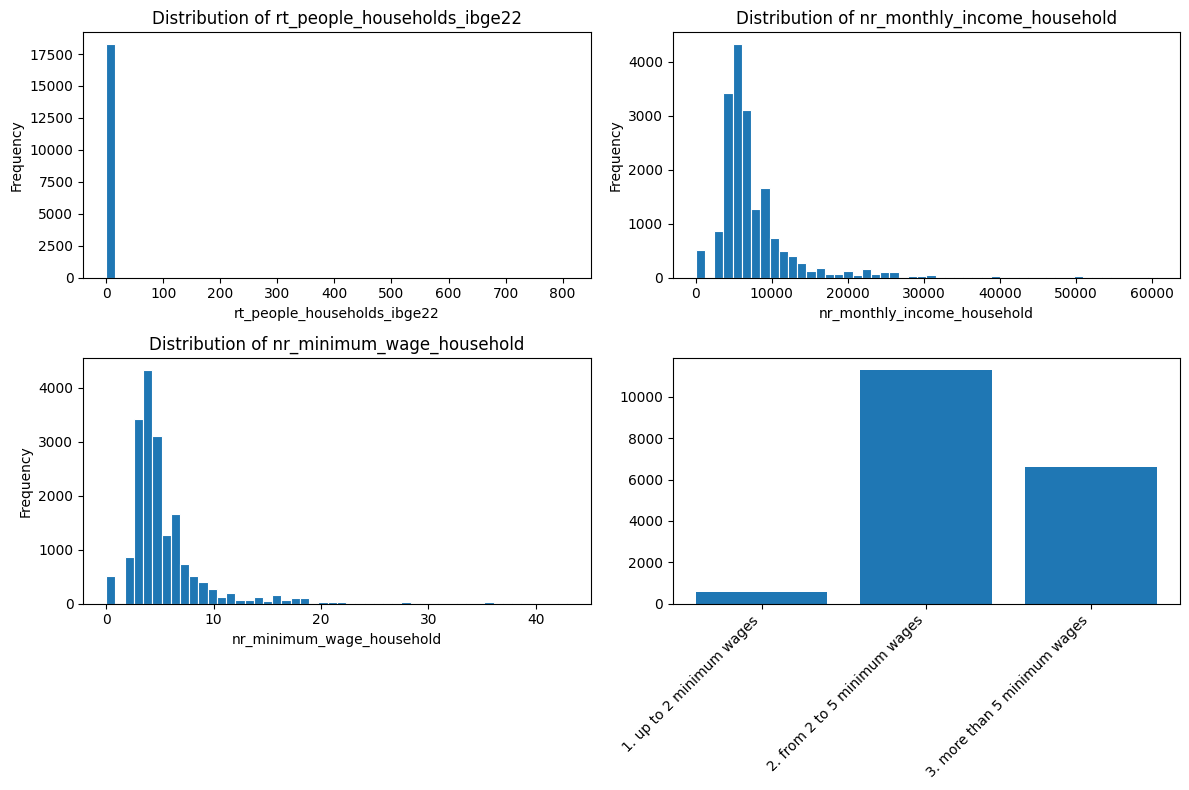

In [82]:
# check distribution of these columns
cols_plot = [
    'rt_people_households_ibge22',
    'nr_monthly_income_household',
    'nr_minimum_wage_household',
    'ds_minimum_wage_range_household'
]

n_plots = len(cols_plot)
n_rows = int(np.ceil(n_plots / 2))
n_cols = int(np.ceil(n_plots / n_rows))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(cols_plot):
    ax = axes[i]
    data = h3_index_filtered[col].dropna()
    ax.hist(data, bins=50, edgecolor='white', linewidth=0.8)
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    # rotate x labels if they are categorical
    if data.dtype == 'object':
        categories = sorted(data.unique())
        counts = data.value_counts().reindex(categories).fillna(0).values
        # replace the histogram with a categorical bar plot and set ticks before labels
        ax.clear()
        ax.bar(range(len(categories)), counts)
        ax.set_xticks(range(len(categories)))
        ax.set_xticklabels(categories, rotation=45, ha='right')
        

# turn off any unused subplots
for j in range(n_plots, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [83]:
h3_index[[
    'rt_people_households_ibge22',
    'nr_monthly_income_household',
    'nr_minimum_wage_household',
    'ds_minimum_wage_range_household']].describe()

,rt_people_households_ibge22,nr_monthly_income_household,nr_minimum_wage_household
count,22898.000000,23102.000000,23102.000000
mean,2.302749,7426.629447,5.259894
std,13.325745,5523.111804,3.911477
min,0.088889,0.000000,0.000000
25%,1.703704,4792.310000,3.390000
50%,2.140625,5943.520000,4.210000
75%,2.483766,7969.030000,5.640000
max,808.400000,60680.680000,42.970000


/home/anabeatrizfig/.pyenv/versions/ml_geo/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


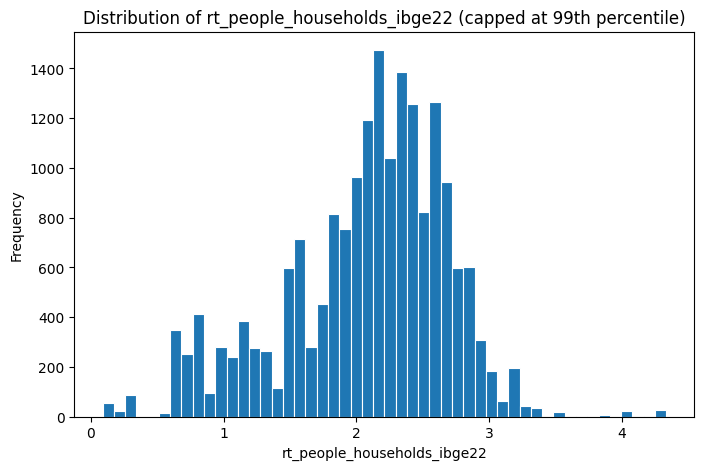

In [84]:
# fix outliers of rt_people_households_ibge22 columns - cap at 99th percentile
q99 = h3_index_filtered['rt_people_households_ibge22'].quantile(0.999)

# fill values above the 99th percentile with the medium value
h3_index_filtered['rt_people_households_ibge22'] = h3_index_filtered['rt_people_households_ibge22'].apply(lambda x: x if x <= q99 else h3_index_filtered['rt_people_households_ibge22'].median())

# redo the distribution plot
plt.figure(figsize=(8, 5))
data = h3_index_filtered['rt_people_households_ibge22'].dropna()
plt.hist(data, bins=50, edgecolor='white', linewidth=0.8)
plt.title('Distribution of rt_people_households_ibge22 (capped at 99th percentile)')
plt.xlabel('rt_people_households_ibge22')
plt.ylabel('Frequency')
plt.show()

In [85]:
h3_index_filtered[[
    'nr_monthly_income_household',
    'nr_minimum_wage_household'
]].head()

,nr_monthly_income_household,nr_minimum_wage_household
0,8041.04,5.69
1,10893.25,7.71
2,8690.00,6.15
3,14203.97,10.06
4,8041.04,5.69


In [86]:
# fill missing values with median - numeric columns

for col in ['rt_people_households_ibge22',
            'nr_monthly_income_household']:
    median_value = h3_index_filtered[col].median()
    h3_index_filtered[col].fillna(median_value, inplace=True)

# recalculate nr_minimum_wage_household based on the new filled values
h3_index_filtered['nr_minimum_wage_household'] = (h3_index_filtered['nr_monthly_income_household'] / 1412).round(2)

# adjust missing values in categorical columns of income
h3_index_filtered['ds_minimum_wage_range_household'] = np.where(h3_index_filtered['nr_minimum_wage_household'] <= 2, '1. up to 2 minimum wages',
                                                        np.where(h3_index_filtered['nr_minimum_wage_household'] <= 5, '2. from 2 to 5 minimum wages',
                                                            np.where(h3_index_filtered['nr_minimum_wage_household'] > 5, '3. more than 5 minimum wages',
                                                                '4. no information')))

/tmp/ipykernel_31696/1900459145.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  h3_index_filtered[col].fillna(median_value, inplace=True)
/tmp/ipykernel_31696/1900459145.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h3_index_filtered[col].fillna(median_value, inplace=True)
/tmp/ipykernel_31696/1900459145.py:6: FutureWarning: A value 

In [88]:
h3_index_filtered.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 18905 entries, 0 to 23635
Data columns (total 25 columns):
 #   Column                                Non-Null Count  Dtype   
---  ------                                --------------  -----   
 0   h3_index                              18905 non-null  object  
 1   h3_resolution                         18905 non-null  int64   
 2   nm_city                               18905 non-null  object  
 3   nm_state_abbrev                       18905 non-null  object  
 4   fl_slope_class_1                      18905 non-null  int64   
 5   fl_slope_class_2                      18905 non-null  int64   
 6   fl_slope_class_3                      18905 non-null  int64   
 7   fl_slope_class_4                      18905 non-null  int64   
 8   nr_distance_urban_growth_2020_2022_m  18905 non-null  float64 
 9   nr_distance_road_m                    18905 non-null  float64 
 10  nr_distance_highways_m                18905 non-null  int64   
 11 

In [89]:
# check if there are still missing values
missing = h3_index_filtered.isnull().sum()

print(missing[missing > 0].sort_values(ascending=False))

Series([], dtype: int64)


In [90]:
h3_index_filtered.columns

Index(['h3_index', 'h3_resolution', 'nm_city', 'nm_state_abbrev',
       'fl_slope_class_1', 'fl_slope_class_2', 'fl_slope_class_3',
       'fl_slope_class_4', 'nr_distance_urban_growth_2020_2022_m',
       'nr_distance_road_m', 'nr_distance_highways_m',
       'nr_distance_urban_area_m', 'nr_poi_positive', 'nr_poi_negative',
       'fl_construction_restriction', 'nr_population_ibge22',
       'nr_households_ibge22', 'rt_people_households_ibge22',
       'nr_monthly_income_household', 'nr_minimum_wage_household',
       'ds_minimum_wage_range_household', 'nr_poor_urban_communities',
       'fl_contaminated_area', 'nr_contaminated_areas', 'geometry'],
      dtype='object')

In [91]:
# recreate nr_slope column based on the slope classes
h3_index_filtered['nr_slope'] = np.where(
    h3_index_filtered['fl_slope_class_4'] == 1, np.ceil(np.random.uniform(30, 45, size=len(h3_index_filtered))),
    np.where(h3_index_filtered['fl_slope_class_3'] == 1, np.ceil(np.random.uniform(15, 30.1, size=len(h3_index_filtered))),
        np.where(h3_index_filtered['fl_slope_class_2'] == 1, np.ceil(np.random.uniform(3, 15.1, size=len(h3_index_filtered))),
            np.where(h3_index_filtered['fl_slope_class_1'] == 1, np.ceil(np.random.uniform(0, 3.1, size=len(h3_index_filtered))),
                0))))

h3_index_filtered[['nr_slope',
          'fl_slope_class_1',
          'fl_slope_class_2',
          'fl_slope_class_3',
          'fl_slope_class_4']].head()

/home/anabeatrizfig/.pyenv/versions/ml_geo/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,nr_slope,fl_slope_class_1,fl_slope_class_2,fl_slope_class_3,fl_slope_class_4
0,23.0,1,1,1,0
1,17.0,1,1,1,0
2,5.0,1,1,0,0
3,6.0,1,1,0,0
4,7.0,1,1,0,0


In [92]:
# remove slope class columns
h3_index_filtered = h3_index_filtered.drop(columns=[
    'fl_slope_class_1',
    'fl_slope_class_2',
    'fl_slope_class_3',
    'fl_slope_class_4'
])

# Final distribution

In [93]:
h3_index_filtered.columns

Index(['h3_index', 'h3_resolution', 'nm_city', 'nm_state_abbrev',
       'nr_distance_urban_growth_2020_2022_m', 'nr_distance_road_m',
       'nr_distance_highways_m', 'nr_distance_urban_area_m', 'nr_poi_positive',
       'nr_poi_negative', 'fl_construction_restriction',
       'nr_population_ibge22', 'nr_households_ibge22',
       'rt_people_households_ibge22', 'nr_monthly_income_household',
       'nr_minimum_wage_household', 'ds_minimum_wage_range_household',
       'nr_poor_urban_communities', 'fl_contaminated_area',
       'nr_contaminated_areas', 'geometry', 'nr_slope'],
      dtype='object')

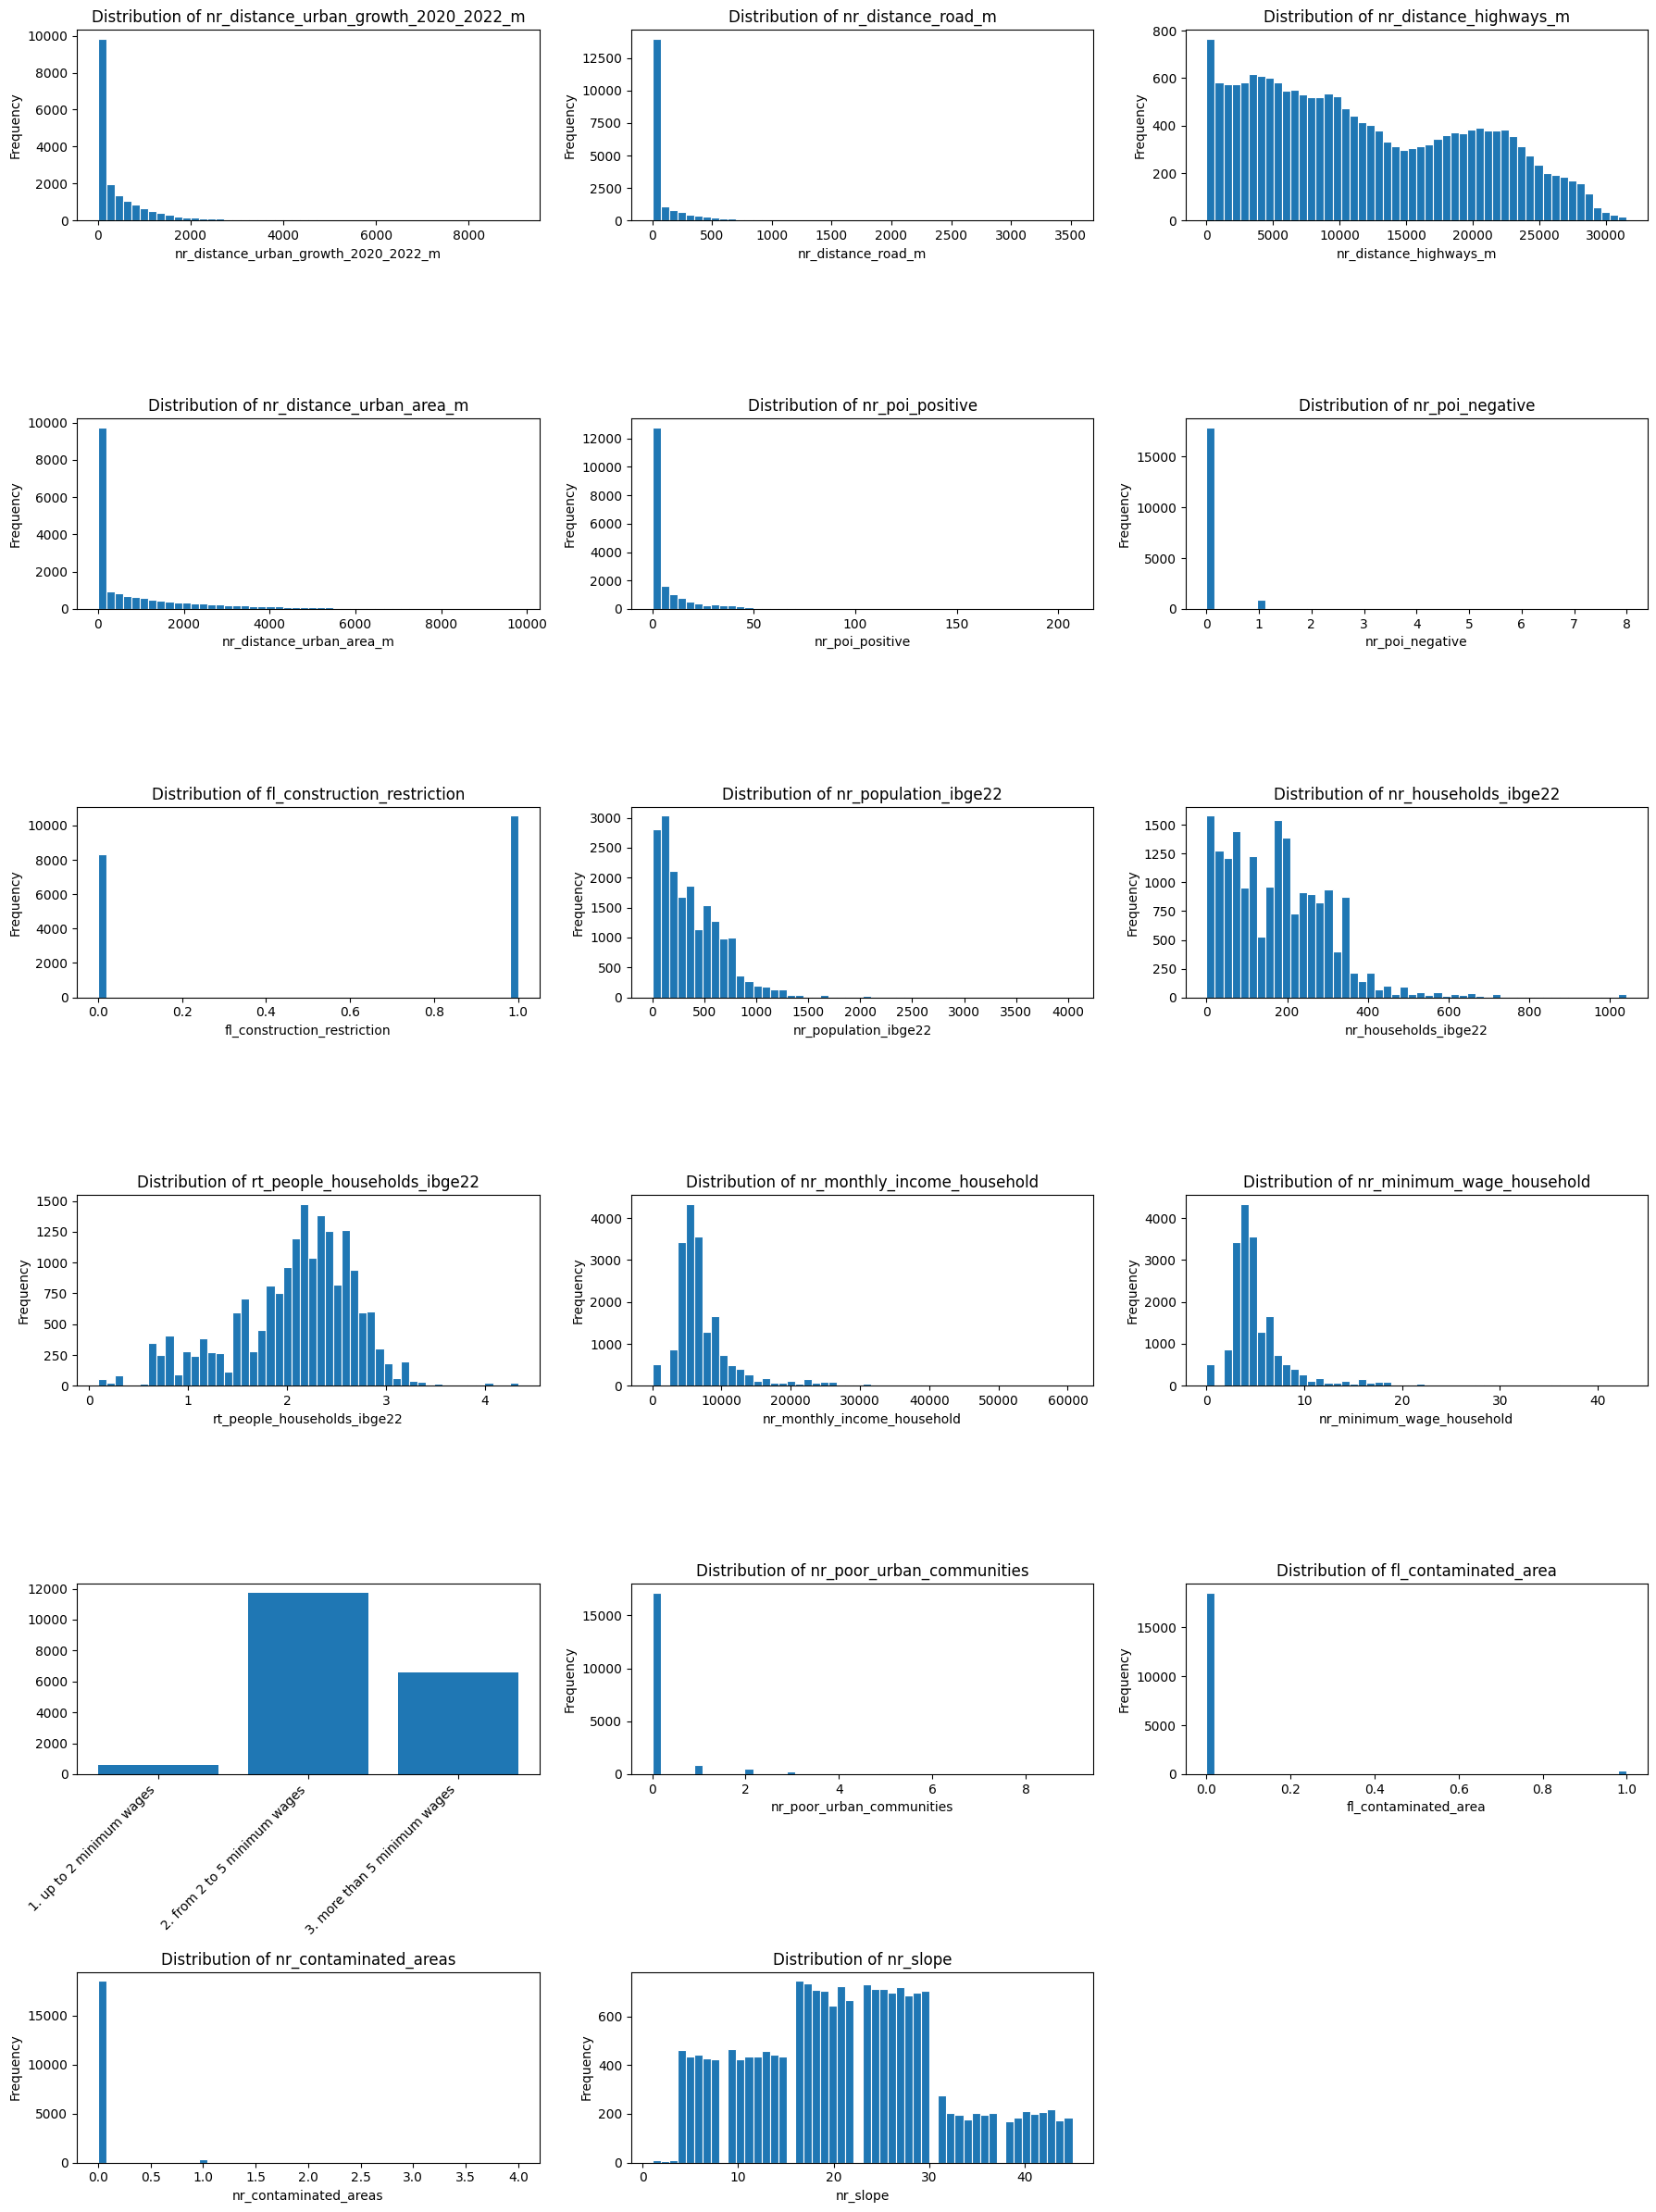

In [95]:
# plot final distribution of all columns

# check distribution of these columns
cols_plot = [
    'nr_distance_urban_growth_2020_2022_m', 'nr_distance_road_m',
    'nr_distance_highways_m', 'nr_distance_urban_area_m',
    'nr_poi_positive', 'nr_poi_negative', 'fl_construction_restriction',
    'nr_population_ibge22', 'nr_households_ibge22',
    'rt_people_households_ibge22', 'nr_monthly_income_household',
    'nr_minimum_wage_household', 'ds_minimum_wage_range_household',
    'nr_poor_urban_communities', 'fl_contaminated_area',
    'nr_contaminated_areas', 'nr_slope'
]

n_plots = len(cols_plot)
n_rows = int(np.ceil(n_plots / 3))
n_cols = int(np.ceil(n_plots / n_rows))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(cols_plot):
    ax = axes[i]
    data = h3_index_filtered[col].dropna()
    ax.hist(data, bins=50, edgecolor='white', linewidth=0.8)
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    # rotate x labels if they are categorical
    if data.dtype == 'object':
        categories = sorted(data.unique())
        counts = data.value_counts().reindex(categories).fillna(0).values
        # replace the histogram with a categorical bar plot and set ticks before labels
        ax.clear()
        ax.bar(range(len(categories)), counts)
        ax.set_xticks(range(len(categories)))
        ax.set_xticklabels(categories, rotation=45, ha='right')
        

# turn off any unused subplots
for j in range(n_plots, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [96]:
# save the cleaned geopackage
h3_index_filtered.to_file(f'{LOCAL_FILE_PATH}h3_index_preprocessed_EN.gpkg', driver='GPKG')